# Load and tweet random Argo float data of the day

In [1]:
import os
from pathlib import Path
import twitter
import xarray as xr
import pandas as pd
import numpy as np
from argopy import DataFetcher as ArgoDataFetcher
from argopy.stores import indexstore, indexfilter_box
import argopy

from matplotlib import pyplot as plt
from matplotlib import image
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature = cfeature.NaturalEarthFeature(category='physical', name='land',
                                                scale='50m', facecolor=[0.4, 0.6, 0.7])
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 16

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

# Load one random Argo profile reported today

## Download this week index

In [2]:
from ftplib import FTP
# ftp://ftp.ifremer.fr/ifremer/argo/ar_index_this_week_prof.txt
index_file = './ar_index_this_week_prof.txt'

with FTP("ftp.ifremer.fr") as ftp:
    ftp.login('anonymous','anonymous')
    ftp.cwd('/ifremer/argo/')
    gFile = open(index_file, "wb")
    ftp.retrbinary('RETR ar_index_this_week_prof.txt', gFile.write)
    gFile.close()

## Randomly select one profile

In [3]:
DATE_end = pd.to_datetime('now')
DATE_start = DATE_end - pd.DateOffset(hours=24.0)
# print(DATE_start)

filt = indexfilter_box(BOX=[-180, 180, -90, 90, DATE_start, DATE_end])
print(filt.BOX)
df = indexstore(index_file=index_file).read_csv(filt)
df['wmo'] = df['file'].apply(lambda x: int(x.split('/')[1]))
print("%i Argo profiles reported today, since %s" % (df.shape[0], DATE_start))

# Randomly select one profile:
df = df.sample(1)
df

[-180, 180, -90, 90, Timestamp('2021-01-17 08:43:18.183793'), Timestamp('2021-01-18 08:43:18.183793')]
309 Argo profiles reported today, since 2021-01-17 08:43:18.183793


,file,date,latitude,longitude,ocean,profiler_type,institution,date_update,wmo
111,aoml/5905082/profiles/R5905082_143.nc,2021-01-17 22:35:28,15.147,58.990002,I,846,AO,2021-01-18 01:01:32,5905082


## Fetch all float data from ftp

In [4]:
Path("dac").mkdir(parents=True, exist_ok=True)

dac = df['file'].values[0].split('/')[0]
wmo = df['wmo'].values[0]
cmd = "rsync -avzh --delete vdmzrs.ifremer.fr::argo/%s/%s dac/%s" % (dac, wmo, dac)
print(cmd)
os.system(cmd)

rsync -avzh --delete vdmzrs.ifremer.fr::argo/aoml/5905082 dac/aoml


0

In [5]:
last_cycle = int(df['file'].values[0].split('/')[-1].split("_")[-1].split('.')[0])
print(last_cycle)

143


## Load data with argopy

In [6]:
with argopy.set_options(local_ftp='.'):
#     ds = ArgoDataFetcher(src='localftp', mode='expert').float([df['wmo'].values[0]]).to_xarray()
    ds = ArgoDataFetcher(src='localftp', mode='expert').profile([df['wmo'].values[0]], last_cycle).to_xarray()
    ds = ds.argo.point2profile()
ds

<xarray.Dataset>
Dimensions:                   (N_LEVELS: 511, N_PROF: 1)
Coordinates:
  * N_PROF                    (N_PROF) int64 0
  * N_LEVELS                  (N_LEVELS) int64 0 1 2 3 4 ... 506 507 508 509 510
    TIME                      (N_PROF) datetime64[ns] 2021-01-17T22:35:28.002...
    LATITUDE                  (N_PROF) float64 15.15
    LONGITUDE                 (N_PROF) float64 58.99
Data variables:
    CONFIG_MISSION_NUMBER     (N_PROF) int64 143
    CYCLE_NUMBER              (N_PROF) int64 143
    DATA_CENTRE               (N_PROF) <U2 'AO'
    DATA_MODE                 (N_PROF) <U1 'A'
    DATA_STATE_INDICATOR      (N_PROF) <U4 '2B  '
    DC_REFERENCE              (N_PROF) <U32 '7023                            '
    DIRECTION                 (N_PROF) <U1 'A'
    FIRMWARE_VERSION          (N_PROF) <U32 '070115                          '
    FLOAT_SERIAL_NO           (N_PROF) <U32 '7362                            '
    PI_NAME                   (N_PROF) <U64 'STEPHEN RISER                   ...
    PLATFORM_NUMBER           (N_PROF) int64 5905082
    PLATFORM_TYPE             (N_PROF) <U32 'APEX                            '
    POSITIONING_SYSTEM        (N_PROF) <U8 'GPS     '
    POSITION_QC               (N_PROF) int64 1
    PRES                      (N_PROF, N_LEVELS) float32 2.9 4.0 ... 1997.1
    PRES_ADJUSTED             (N_PROF, N_LEVELS) float32 2.9 4.0 ... 1997.1
    PRES_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 nan nan nan ... nan nan
    PRES_ADJUSTED_QC          (N_PROF) int64 1
    PRES_QC                   (N_PROF) int64 1
    PROFILE_PRES_QC           (N_PROF) <U1 'A'
    PROFILE_PSAL_QC           (N_PROF) <U1 'F'
    PROFILE_TEMP_QC           (N_PROF) <U1 'A'
    PROJECT_NAME              (N_PROF) <U64 'UW, Argo                        ...
    PSAL                      (N_PROF, N_LEVELS) float32 36.439 ... 35.218
    PSAL_ADJUSTED             (N_PROF, N_LEVELS) float32 36.439 ... 35.218
    PSAL_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 nan nan nan ... nan nan
    PSAL_ADJUSTED_QC          (N_PROF) int64 4
    PSAL_QC                   (N_PROF) int64 4
    TEMP                      (N_PROF, N_LEVELS) float32 25.179 25.176 ... 3.244
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 25.179 25.176 ... 3.244
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 nan nan nan ... nan nan
    TEMP_ADJUSTED_QC          (N_PROF) int64 1
    TEMP_QC                   (N_PROF) int64 1
    TIME_LOCATION             (N_PROF) datetime64[ns] 2021-01-17T22:49:30.002...
    TIME_QC                   (N_PROF) int64 1
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 'Primary sampling: mixed [deep: ...
    WMO_INST_TYPE             (N_PROF) int64 846
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         .
    Fetched_by:           gmaze
    Fetched_date:         2021/01/18
    Fetched_constraints:  phy;WMO5905082_CYC143
    Fetched_uri:          ./dac/aoml/5905082/profiles/R5905082_143.nc
    history:              Transformed with point2profile

In [7]:
# Select the profile to work with:
this_ds = ds.isel(N_PROF=-1) # The last profile to date
this_ds

<xarray.Dataset>
Dimensions:                   (N_LEVELS: 511)
Coordinates:
    N_PROF                    int64 0
  * N_LEVELS                  (N_LEVELS) int64 0 1 2 3 4 ... 506 507 508 509 510
    TIME                      datetime64[ns] 2021-01-17T22:35:28.002411264
    LATITUDE                  float64 15.15
    LONGITUDE                 float64 58.99
Data variables:
    CONFIG_MISSION_NUMBER     int64 143
    CYCLE_NUMBER              int64 143
    DATA_CENTRE               <U2 'AO'
    DATA_MODE                 <U1 'A'
    DATA_STATE_INDICATOR      <U4 '2B  '
    DC_REFERENCE              <U32 '7023                            '
    DIRECTION                 <U1 'A'
    FIRMWARE_VERSION          <U32 '070115                          '
    FLOAT_SERIAL_NO           <U32 '7362                            '
    PI_NAME                   <U64 'STEPHEN RISER                            ...
    PLATFORM_NUMBER           int64 5905082
    PLATFORM_TYPE             <U32 'APEX                            '
    POSITIONING_SYSTEM        <U8 'GPS     '
    POSITION_QC               int64 1
    PRES                      (N_LEVELS) float32 2.9 4.0 6.0 ... 1947.4 1997.1
    PRES_ADJUSTED             (N_LEVELS) float32 2.9 4.0 6.0 ... 1947.4 1997.1
    PRES_ADJUSTED_ERROR       (N_LEVELS) float32 nan nan nan nan ... nan nan nan
    PRES_ADJUSTED_QC          int64 1
    PRES_QC                   int64 1
    PROFILE_PRES_QC           <U1 'A'
    PROFILE_PSAL_QC           <U1 'F'
    PROFILE_TEMP_QC           <U1 'A'
    PROJECT_NAME              <U64 'UW, Argo                                 ...
    PSAL                      (N_LEVELS) float32 36.439 36.438 ... 35.229 35.218
    PSAL_ADJUSTED             (N_LEVELS) float32 36.439 36.438 ... 35.229 35.218
    PSAL_ADJUSTED_ERROR       (N_LEVELS) float32 nan nan nan nan ... nan nan nan
    PSAL_ADJUSTED_QC          int64 4
    PSAL_QC                   int64 4
    TEMP                      (N_LEVELS) float32 25.179 25.176 ... 3.378 3.244
    TEMP_ADJUSTED             (N_LEVELS) float32 25.179 25.176 ... 3.378 3.244
    TEMP_ADJUSTED_ERROR       (N_LEVELS) float32 nan nan nan nan ... nan nan nan
    TEMP_ADJUSTED_QC          int64 1
    TEMP_QC                   int64 1
    TIME_LOCATION             datetime64[ns] 2021-01-17T22:49:30.002431744
    TIME_QC                   int64 1
    VERTICAL_SAMPLING_SCHEME  <U256 'Primary sampling: mixed [deep: discrete,...
    WMO_INST_TYPE             int64 846
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         .
    Fetched_by:           gmaze
    Fetched_date:         2021/01/18
    Fetched_constraints:  phy;WMO5905082_CYC143
    Fetched_uri:          ./dac/aoml/5905082/profiles/R5905082_143.nc
    history:              Transformed with point2profile

# Create and save figures

## Utilities

In [8]:
def plot_profile(this, x='TEMP', y='PRES', title='?'):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,8), dpi=120)
    # fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(14,8))
    # axes = axes.flatten()
    # [ax.grid() for ax in axes]
#     axes.set_ylim([0, 2000])

    # ax = ax.flatten()
    this.plot.scatter(ax=axes, x=x, y=y, s=2)
    
    ymin, ymax = axes.get_ylim()
#     print(ymin, ymax)
    axes.set_ylim([0, ymax])
    axes.invert_yaxis()
    
    axes.set_title(title)

In [9]:
quadrant = 'E' if this_ds['LONGITUDE'] > 0 else 'W'
hemisphere = 'N' if this_ds['LATITUDE'] > 0 else 'S'
print(hemisphere, quadrant)

N E


In [10]:
from argopy.utilities import load_dict, mapp_dict
profiler_dictionnary = load_dict('profilers')
float_model = mapp_dict(profiler_dictionnary, this_ds['WMO_INST_TYPE'].values[np.newaxis][0])

In [11]:
# t = pd.to_datetime(str(this_ds['TIME'].values)).strftime('%Y.%m.%dT%H:%M:%S')
t = pd.to_datetime(str(this_ds['TIME'].values)).strftime('%A %d of %B %Y, %H:%M:%S UTC')
p = "%0.3f%s, %0.3f%s" % (np.abs(this_ds['LATITUDE']), hemisphere, np.abs(this_ds['LONGITUDE']), quadrant)
profile_title = "Float %s, cycle %i\nDate: %s\nPosition: %s" % (wmo, this_ds['CYCLE_NUMBER'], t, p)
print(profile_title, "\n")

Float 5905082, cycle 143
Date: Sunday 17 of January 2021, 22:35:28 UTC
Position: 15.147N, 58.990E 



## Plots

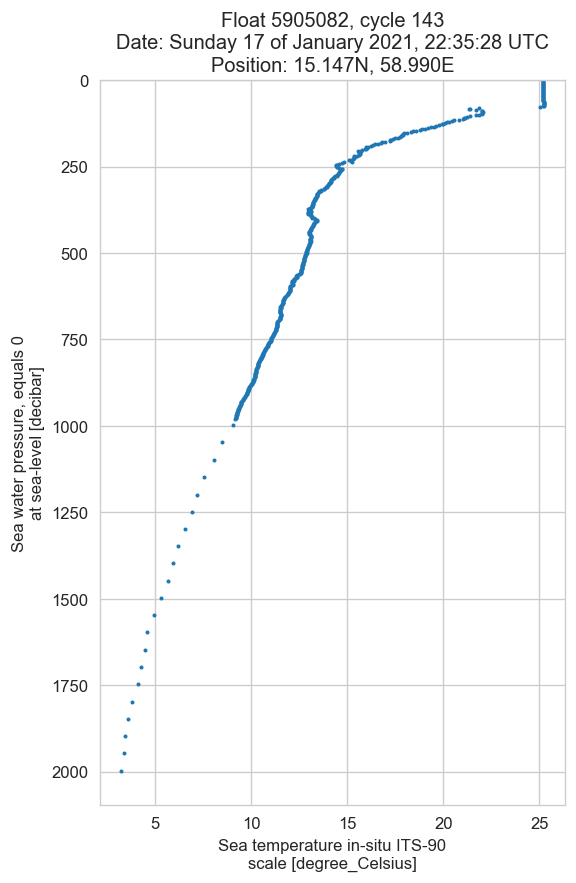

In [12]:
plot_profile(ds.isel(N_PROF=-1), x='TEMP', y='PRES', title=profile_title)
plt.savefig('TEMP.jpeg')

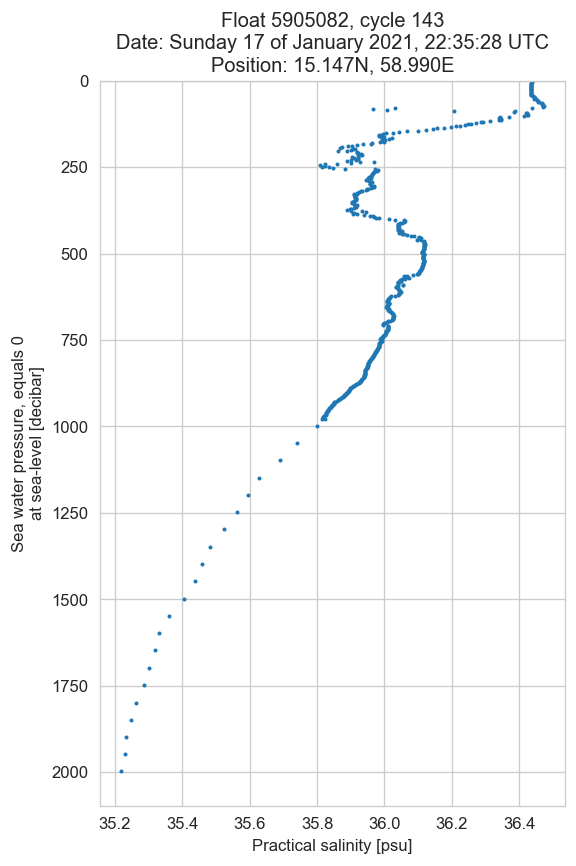

In [13]:
plot_profile(ds.isel(N_PROF=-1), x='PSAL', y='PRES', title=profile_title)
plt.savefig('PSAL.jpeg')

# Tweet this !

In [15]:
consumer_key, consumer_secret, access_key, access_secret = os.environ['TWITTER_SECRET'].split(':')

api = twitter.Api(consumer_key=consumer_key,
                  consumer_secret=consumer_secret,
                  access_token_key=access_key,
                  access_token_secret=access_secret)
api

In [16]:
media = []
for fname in ['TEMP.jpeg', 'PSAL.jpeg']:
    with open(fname, 'rb') as f:
        media.append(api.UploadMediaChunked(f))

In [17]:
# Find Twitter emoji: https://www.piliapp.com/twitter-symbols/

t = pd.to_datetime(str(this_ds['TIME'].values)).strftime('%A %d of %B %Y, %H:%M:%S UTC')
p = "%0.3f%s, %0.3f%s" % (np.abs(this_ds['LATITUDE']), hemisphere, np.abs(this_ds['LONGITUDE']), quadrant)
# long_title = "▶ Float %s, cycle %i ◀\n🗓 Date: %s\n🗺 Position: %s\n📏 Number of levels: %i\n🤖 Float model: %s\n🔬 Responsible Scientist: %s\n💳 Project: %s" % (
#     wmo, this_ds['CYCLE_NUMBER'], 
#     t, 
#     p, 
#     len(this_ds['N_LEVELS']),
#     float_model,
#     this_ds['PI_NAME'].values[np.newaxis][0].strip().title(), 
#     this_ds['PROJECT_NAME'].values[np.newaxis][0].strip())

long_title = "▶ Float %s, Cycle %i 🗓%s 🗺%s 📏%i measurements 🤖%s 🔬%s 💳%s" % (
    wmo, this_ds['CYCLE_NUMBER'], 
    t, 
    p, 
    len(this_ds['N_LEVELS']),
    float_model,
    this_ds['PI_NAME'].values[np.newaxis][0].strip().title(), 
    this_ds['PROJECT_NAME'].values[np.newaxis][0].strip())

print(long_title)

▶ Float 5905082, Cycle 143 🗓Sunday 17 of January 2021, 22:35:28 UTC 🗺15.147N, 58.990E 📏511 measurements 🤖Webb Research, Seabird sensor 🔬Stephen Riser 💳UW, Argo


In [18]:
# t = pd.to_datetime(str(ds['TIME'].isel(N_PROF=-1).values)).strftime('%Y.%m.%dT%H:%M:%S')
# caption = (f'Argo float data\n'
#            f'Float ID: {wmo}\n'
#            f'Profile date: {t}\n'
#            f'https://fleetmonitoring.euro-argo.eu/float/{wmo}')
# caption

In [19]:
t = pd.to_datetime(str(ds['TIME'].isel(N_PROF=-1).values)).strftime('%Y.%m.%dT%H:%M:%S')
caption = (f'🏆 Here is the Argo profile of the day 🎉\n'
           f'{long_title}\n'
           f'https://fleetmonitoring.euro-argo.eu/float/{wmo} '
           f'#argofloat')
caption

'🏆 Here is the Argo profile of the day 🎉\n▶ Float 5905082, Cycle 143 🗓Sunday 17 of January 2021, 22:35:28 UTC 🗺15.147N, 58.990E 📏511 measurements 🤖Webb Research, Seabird sensor 🔬Stephen Riser 💳UW, Argo\nhttps://fleetmonitoring.euro-argo.eu/float/5905082 #argofloat'

In [20]:
if len(caption)>280:
    caption = caption[0:275] + '...'

In [21]:
print(len(caption))

261


In [22]:
api.PostUpdate(caption, media=media)

Status(ID=1351087808459517956, ScreenName=argobot84, Created=Mon Jan 18 08:43:30 +0000 2021, Text='🏆 Here is the Argo profile of the day 🎉\n▶ Float 5905082, Cycle 143 🗓Sunday 17 of January 2021, 22:35:28 UTC 🗺15.147… https://t.co/gqfeLyCvRq')

***
This repository is maintained by:
<div>
<img src="https://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>